# Stationrank

In [1]:
import os
import time
import json
import pygraphviz

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import datetime as dt
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [332]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
from shapely.geometry import Point, LineString
from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from datetime import datetime, timedelta
from numpy import nan

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [5]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [6]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [20]:
# Collect features
features = []
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

## Load stations dataset (didok)

In [10]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [11]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'ABKUERZUNG', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head(5)

,BPUIC,BEZEICHNUNG_OFFIZIELL,ABKUERZUNG,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",NaN,-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",NaN,-14.764508,35.330601
2,8519024,Basel SBB RB West,BRBW,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,BRBO,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",NaN,0.379039,47.265918


### Locations in project as BPUIC

In [12]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations.head()

,HALTESTELLEN_NAME,BPUIC
0,Basel Bad Bf,8500090
1,Basel SBB,8500010
2,Schaffhausen,8503424
3,Zürich HB,8503000
4,Interlaken Ost,8507492


### Georeferenced locations by BPUIC

In [13]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    abb = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][4]
    loc = [lon, lat]
    geopos.append(loc)
    abbreviation.append(abb)

In [476]:
locations['abbreviation'] = abbreviation
locations['geopos'] = geopos
locations.head(5)

,HALTESTELLEN_NAME,BPUIC,abbreviation,geopos
0,Basel Bad Bf,8500090,BAD,"[7.60728379, 47.56814685]"
1,Basel SBB,8500010,BS,"[7.58955093, 47.54740464]"
2,Schaffhausen,8503424,SH,"[8.632719999999999, 47.69827999]"
3,Zürich HB,8503000,ZUE,"[8.540189999999999, 47.378170000000004]"
4,Interlaken Ost,8507492,IO,"[7.869, 46.69050001]"


## Preprocessing

In [15]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [17]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [18]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [21]:
# Collect diaries
diaries = []

for feature in tqdm(features):

    # Diary of routes
    diary = []
    for route in tqdm(
            feature.FAHRT_BEZEICHNER.unique(),
            desc=feature['BETRIEBSTAG'].unique()[0]):

        df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        if len(df['HALTESTELLEN_NAME']) > 1:

            df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
            df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

            # Sort routes by scheduled departure
            df = df.sort_values(
                by='ABFAHRTSZEIT', ascending=True, na_position='last')

            df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
            df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

            # Check for timetable errors
            if any(df['running'].values.ravel() < 0):
                continue
            if any(df['dwell'].values.ravel() < 0):
                continue

            df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

            sentence = []
            for i, j, k, l in df[[
                    'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
            ]].values:
                if pd.isna(j) or pd.isna(l):
                    sentence.append([i])
                elif pd.isna(k):
                    sentence.append([i])
                    break
                else:
                    sentence.append([i] * int(k))
                    sentence.append([i + '=>' + j] * int(l))

            flattened = [item for sublist in sentence for item in sublist]
            dic = timeline(flattened, df)
            if len(dic) > 1440:
                print(len(dic))
                break
            diary.append(dic)

    # Fill in the diaries
    diaries.append(pd.DataFrame(diary))

In [27]:
print(flattened)

['Tirano', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Le Prese', 'Le Prese', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Poschiavo', 'Poschiavo', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 

## Save the diaries for later use

In [22]:
# Export all diaries
for i, diary in enumerate(diaries):
    path = 'data/istdaten/{}/diaries/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    diary.to_pickle(path)

## Load preprocessed data

In [407]:
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

## Model construction

In [408]:
# Collect starting vectors
vectors = []
# Collect transition matrices
matrices = []
# Collect states
states = []

for diary in tqdm(Diaries):

    # Dictionary of stations
    dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    # Initialize a n*1 initial start vector
    t = (n)
    Distribution = pd.DataFrame(np.zeros(t))
    Initial = pd.DataFrame(np.zeros(t))
    Frequency = pd.DataFrame(np.zeros(t))
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for row in tqdm(diary.values):
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
        
        # Initial vector
        pos_i = stations.loc[stations['station'] == stops[0]].index[0]
        Initial.iloc[pos_i] += 1
            
        # Transition matrix
        for i in range(len(stops) - 1):
            pos1 = stations.loc[stations['station'] == stops[i]].index[0]
            pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
            matrix.iloc[pos1, pos2] += 1
            
    # Fill in the vectors
    s = matrix.sum()
    Distribution['Station'] = dic['station']
    Distribution['Init'] = Initial.div(Initial.sum(axis=0), axis=1)
    Distribution['Freq'] = s/sum(s)
    Distribution = Distribution.drop(columns=[0])
    vectors.append(Distribution)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

## Save the model for later use

In [409]:
# Export all vectors
for i, vector in enumerate(vectors):
    path = 'data/istdaten/{}/vectors/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [410]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

## Loading the model

In [467]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [468]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [469]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}.2019'.format(i, imonth)
    strings.append(string)

In [470]:
# Load transition matrices
TMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [471]:
# Now convert to probabilities
singularities = []
for i, TM in tqdm(enumerate(TMs)):
    eps = .001
    count = 0
    for row in tqdm(TM.values):
        singularities.append([])
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            absorbing = Vs[i].iloc[count][0]
            print('Absorbing state at', absorbing, i, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            singularity = Vs[i].iloc[count][0]
            singularities[i].append(singularity)
            print('Singularity at', singularity, i, '\n')
            row[:] = eps
            row[count] = 1.0
            _s = sum(row)
            row[:] = [f/_s for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

Singularity at Murg 8 




Singularity at St-Gingolph 18 




Singularity at Heiden 20 




Singularity at Monthey 22 




Singularity at Basel SBB GB 24 

Singularity at Basel St. Jakob 24 




Singularity at Basel St. Jakob 28 




In [472]:
# Overview of singularities in the system by day of occurance
singular = pd.DataFrame(singularities).dropna(how ='all')
singular

,0,1
8,Murg,None
18,St-Gingolph,None
20,Heiden,None
22,Monthey,None
24,Basel SBB GB,Basel St. Jakob
28,Basel St. Jakob,None


In [473]:
# Matrix size
sizes = []
for TM in TMs:
    s = TM.values.ravel()
    size = round(sum(s)).astype(int)
    sizes.append(size)

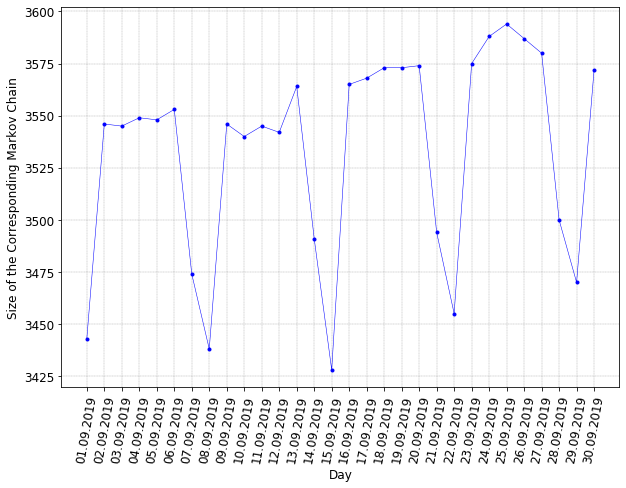

In [474]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

## Analysis

In [420]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

### Using Power Iteration to calculate the steady state probabilities, Pi

In [421]:
Pi = []
Mixing_times = []

for TM in TMs:
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

Iterating 1883 times in 33.03899073600769
Iterating 1572 times in 28.73286533355713
Iterating 1464 times in 26.093929290771484
Iterating 1452 times in 26.446879148483276
Iterating 1523 times in 27.698464155197144
Iterating 1645 times in 28.760180711746216
Iterating 1884 times in 35.90817356109619
Iterating 1978 times in 33.78487539291382
Iterating 1972 times in 35.418893814086914
Iterating 1309 times in 24.05491018295288
Iterating 1417 times in 26.83994483947754
Iterating 1243 times in 14.58835244178772
Iterating 1425 times in 12.563280820846558
Iterating 1497 times in 11.248613119125366
Iterating 1661 times in 12.116879940032959
Iterating 1337 times in 10.4935142993927
Iterating 1247 times in 9.725789308547974
Iterating 1280 times in 9.584200382232666
Iterating 1187 times in 8.95100450515747
Iterating 1524 times in 11.78775668144226
Iterating 1704 times in 12.379241704940796
Iterating 1540 times in 10.723921298980713
Iterating 1304 times in 11.077471017837524
Iterating 1531 times in 1

In [422]:
start = 0

### Average mixing time of Markov chains

In [445]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 25
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in trange(n):
    for j in range(len(TMs)):
        _, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

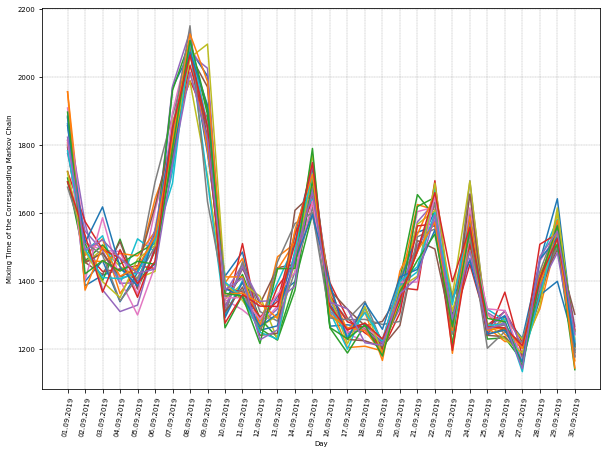

In [446]:
fig = plt.figure(figsize=(10, 7))
for mix in Mixing_times_n_times:
    plt.plot(mix[slice(start, None)])
font = {'size': 12}
plt.rc('font', **font)
plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

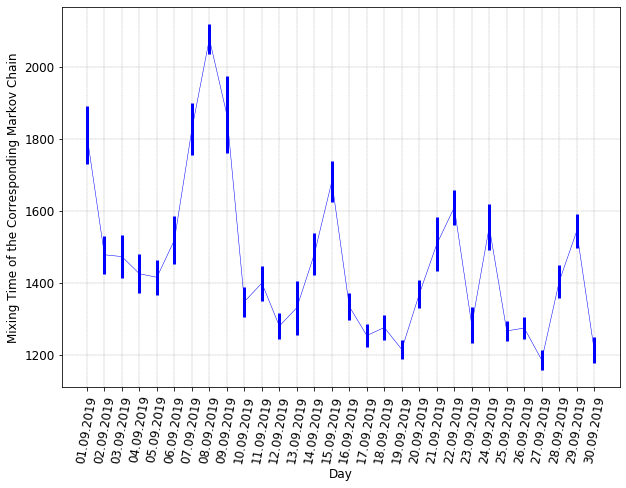

In [447]:
fig = plt.figure(figsize=(10, 7))
yerr = Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(len(TMs[slice(start, None)])),
    Mixing_times_n_times.mean(axis=0)[slice(start, None)],
    yerr=yerr[slice(start, None)],
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.5,
    elinewidth=3)
font = {'size': 12}
plt.rc('font', **font)

plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

In [423]:
def Kemeny_constant(MC):
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [424]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

34332.091473304434 1.0
35846.79705249284 1.0
36113.45077077268 1.0
36250.57873760012 1.0
35953.32159290099 1.0
36459.94783170457 1.0
35431.30666502262 0.9999999999999999
34018.28770307162 0.9999999999999999
36056.0834841646 0.9999999999999998
36028.00000622803 0.9999999999999999
36943.16046868362 1.0
36262.42970985813 1.0
36400.666576508476 1.0
35461.078581121554 1.0
33873.26566636552 0.9999999999999999
36054.49743583123 0.9999999999999999
36046.56571706466 1.0
36004.98200541816 1.0
35942.392042234336 1.0
36422.3552839102 1.0
35425.48403115837 1.0
34081.233642831095 1.0
35763.263975810456 1.0
35861.1968532139 0.9999999999999999
36410.046008746445 0.9999999999999999
36446.66210406855 1.0
36531.76780216703 1.0
35083.56280585374 0.9999999999999999
33723.295067337254 1.0
35822.706964058845 1.0000000000000002


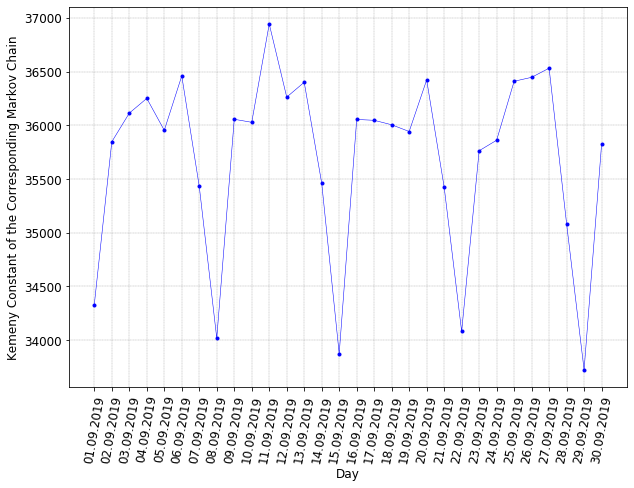

In [425]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Kemenys[slice(start, None)], '.-b', linewidth=.51)

font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
xticks = [s for s in strings]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks[slice(start, None)],
    rotation=80,
    horizontalalignment='center')

plt.show()
plt.close()

In [502]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Freq'] = vector.Freq.values    
    Steady_dist['Init'] = vector.Init.values
    Steady_dist['Date'] = str(datetime(year=2019, month=9, day=int(i + 1)))
    Steady_dist['Flag'] = ~Steady_dist['Station'].str.contains('=>')
    Steady_dist = Steady_dist[['Station', 'Pi', 'Freq', 'Init', 'Date', 'Flag']]
    #Steady_dist = Steady_dist[~Steady_dist['Station'].str.contains('=>')]
    steady_states.append(Steady_dist)

## Results

In [503]:
# Compute pagerank
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank.reset_index()
    stationrank = stationrank.drop(columns=['index'])
    stationranks.append(stationrank)

In [504]:
# Google it!
@interact
def rank(day=(start, len(steady_states) - 1)):
    return stationranks[day].head(20)

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [505]:
# Google it!
@interact
def scatter(day=(start, len(steady_states) - 1)):
    cmap = cm.get_cmap('Spectral_r')
    fig, ax = plt.subplots(figsize=(5.5,5))
    stationranks[day].plot.scatter(x='Freq', y='Pi', s=5, c='Init', cmap=cmap, ax=ax) 

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [511]:
selected_states = []
for state in steady_states:
    state = state[~state['Station'].str.contains('=>')]
    state.set_index('Station', inplace=True)
    selected_states.append(state)

In [513]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')
merge

,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag,...,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag
Station,,,,,,,,,,,,,,,,,,,,,
Aadorf,0.000215,0.000201,0.000000,2019-09-01 00:00:00,True,0.000182,0.000175,0.000000,2019-09-02 00:00:00,True,...,0.000216,0.000202,0.000000,2019-09-29 00:00:00,True,0.000193,0.000184,0.000000,2019-09-30 00:00:00,True
Aarau,0.001428,0.001341,0.009983,2019-09-01 00:00:00,True,0.001326,0.001315,0.009346,2019-09-02 00:00:00,True,...,0.001373,0.001304,0.009849,2019-09-29 00:00:00,True,0.001269,0.001304,0.009420,2019-09-30 00:00:00,True
Aarberg,0.000088,0.000092,0.000000,2019-09-01 00:00:00,True,0.000081,0.000087,0.000000,2019-09-02 00:00:00,True,...,0.000086,0.000087,0.000000,2019-09-29 00:00:00,True,0.000074,0.000083,0.000000,2019-09-30 00:00:00,True
Aarburg-Oftringen,0.000296,0.000288,0.000000,2019-09-01 00:00:00,True,0.000313,0.000317,0.000000,2019-09-02 00:00:00,True,...,0.000279,0.000275,0.000000,2019-09-29 00:00:00,True,0.000290,0.000307,0.000000,2019-09-30 00:00:00,True
Aathal,0.000228,0.000203,0.000000,2019-09-01 00:00:00,True,0.000193,0.000178,0.000000,2019-09-02 00:00:00,True,...,0.000206,0.000191,0.000000,2019-09-29 00:00:00,True,0.000176,0.000167,0.000000,2019-09-30 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zürich Stadelhofen,0.002883,0.002691,0.000000,2019-09-01 00:00:00,True,0.002500,0.002434,0.000000,2019-09-02 00:00:00,True,...,0.002702,0.002548,0.000000,2019-09-29 00:00:00,True,0.002381,0.002343,0.000000,2019-09-30 00:00:00,True
Zürich Tiefenbrunnen,0.000423,0.000397,0.001182,2019-09-01 00:00:00,True,0.000338,0.000330,0.000584,2019-09-02 00:00:00,True,...,0.000404,0.000383,0.001151,2019-09-29 00:00:00,True,0.000330,0.000324,0.000465,2019-09-30 00:00:00,True
Zürich Wiedikon,0.000576,0.000540,0.000000,2019-09-01 00:00:00,True,0.000509,0.000497,0.000000,2019-09-02 00:00:00,True,...,0.000545,0.000512,0.000000,2019-09-29 00:00:00,True,0.000474,0.000469,0.000000,2019-09-30 00:00:00,True


In [514]:
indices = merge.index.values

## Share in Trains per Day (red) compared to structural power (blue) over time

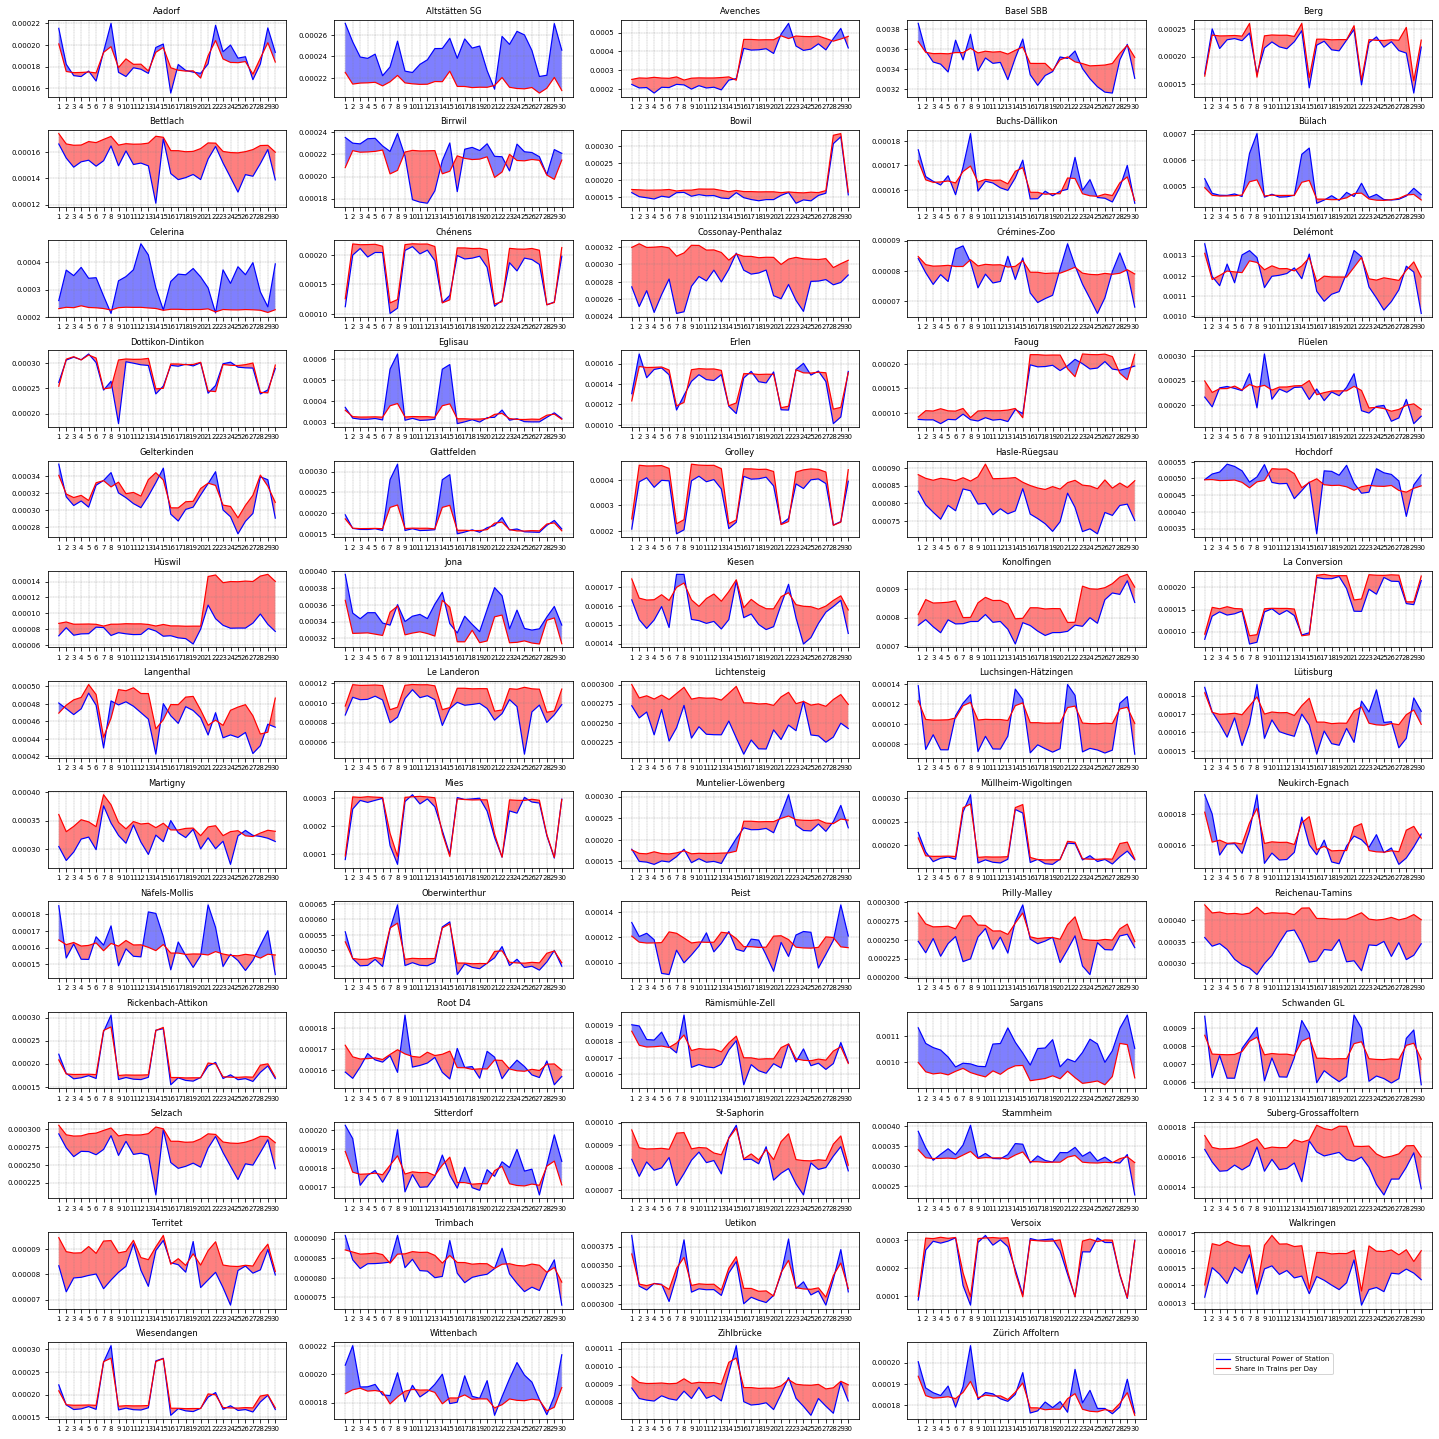

In [515]:
fig = plt.figure(figsize=(20, 20))
font = {'size': 7}
plt.rc('font', **font)

for j, i in enumerate(trange(0, len(indices), 15), 1):

    yPi = merge.loc[indices[i]][0::5].values
    yFreq = merge.loc[indices[i]][1::5].values

    plt.subplot(13, 5, j)
    plt.title(indices[i])

    plt.plot(
        range(len(steady_states)),
        yPi,
        '-b',
        linewidth=1.2,
        label='Structural Power of Station')
    plt.plot(
        range(len(steady_states)),
        yFreq,
        '-r',
        linewidth=1.2,
        label='Share in Trains per Day')
    
    y1 = yPi.astype(float)
    y2 = yFreq.astype(float)
    x = range(len(steady_states))

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)

    label = range(1, len(steady_states) + 1)
    plt.xticks(range(len(steady_states)), label)
    plt.tight_layout()
    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.8, 0.9))
plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [ ]:
# Sensitivity analysis on a single node
def change_node(M, i, percent=10):
    MC = M.copy()
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

In [ ]:
percent = -99
DFs = []
selected_stations = ['Aarau', 'Bern', 'Chur', 'Landquart', 'Olten', 'Zürich HB']

for d in trange(len(TMs)):
    TM = TMs[d]
    names_perturbed = []
    indices_perturbated = []
    Kemenys_perturbed = []
    Kemenys_diff = []
    Pi_perturbed = []
    Pi_diff = []
    e0 = time.time()
    K_normal, pi_normal = Kemeny_constant(TM)

    for station in selected_stations:
        ind = np.where(TM.index == station)[0][0]
        Perturbed_TM = change_node(TM.values, ind, percent)

        K, _ = Kemeny_constant(Perturbed_TM)
        pi, mixing_ = simulate_markov(Perturbed_TM, verbose='off')

        if np.any(pi < 0):
            flag = True
            print('something went wrong!')            
        else:
            flag = False
            indices_perturbated.append(ind)
            names_perturbed.append(station)
            Kemenys_perturbed.append(K)
            Kemenys_diff.append(100 * (K - K_normal) / K_normal)
            Pi_perturbed.append(Init_Pi)
            Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

    print("Sensitivity of TM {}, in {} second".format(
        datetime(year=2019, month=9, day=int(d + 1)),
        time.time() - e0))
    print(names_perturbed)
    print(Kemenys_diff, '\n')
    if not flag:
        DF = pd.DataFrame(index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
        DFs.append(DF)

## Network Visualization

In [ ]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [9], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Date=str(pd.to_datetime(timestamp)[0]))
    df = DFs[index].T.rename(
        columns={
            'Aarau': 'AA',
            'Bern': 'BE',
            'Chur': 'CH',
            'Landquart': 'LA',
            'Olten': 'OL',
            'Zürich HB': 'ZH'
        })
    attrs = pd.concat([df, steady_states[index]], axis=1).T.to_dict()
    #attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Prepare for kepler.gl

In [ ]:
node_features = []
edge_features = []

In [ ]:
for index in trange(len(steady_states)-26):
    G = station_graph(index)
    graph = json_graph.node_link_data(G)
    for props in graph['nodes']:
        pos = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'id']].geopos.values[0]
        feature = Feature(Point(tuple(pos)), properties=props)
        node_features.append(feature)
    for props in graph['links']:
        source = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'source']].geopos.values[0]
        target = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'target']].geopos.values[0]
        feature = Feature(
            LineString([Point(tuple(source)),
                        Point(tuple(target))]), properties=props)
        edge_features.append(feature)

In [ ]:
# Gather all features
graph_features = node_features + edge_features
feature_collection = FeatureCollection(graph_features)

In [ ]:
# Write to file as geojson
with open('data/istdaten/September/map.geojson', 'w') as outfile:
     dump(feature_collection, outfile, indent=2, ensure_ascii=False)
outfile.close()

[See online app here](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/p10n10r99h0lizi/keplergl_snm01s5.json)

### Interactive Plots

In [ ]:
def plot_station_graph(index, size, geo=True, labels=False, target='ZH'):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    pi_ = np.array(list(nx.get_node_attributes(G, target).values()))

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.Accent,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME']
                                                 == key].geopos.values[0])
        plt.figure(figsize=(50, 35))
        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.viridis,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    plt.show()

In [ ]:
interact(
    plot_station_graph,
    index=(0, 29),
    size=(4.5, 6.0),
    geo={True, False},
    labels={True, False},
    target={'AA','BE','CH','LA','OL','ZH'});

## Export the Graph

In [ ]:
# Write to file for further visualization

index=0
write_dot(station_graph(index), 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/markov/01092019.png)